<a href="https://colab.research.google.com/github/aidanjmaldonado/penny-stock-lstm/blob/main/penny_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [212]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import sqlite3
import requests
import sys
import pytz

from library.DataSetProcessor import DataSetProcessor
import matplotlib.pyplot as plt

import pickle







# Create database

In [213]:
# Download database from github repository
historical_url = "https://raw.githubusercontent.com/CSE-115-UCSC/penny-stock-lstm/main/historicaldata.db"
scrape_request = requests.get(historical_url)

try:
  # Contingent on request status
  scrape_request = requests.get(historical_url)
  scrape_request.raise_for_status()

  # Create local database from pull, name 'historicaldata.db'
  with open("historical.db", "wb") as db_file:
    db_file.write(scrape_request.content)

  print("Request to download database succeeded")


except:
  # Report failed request status
  sys.stderr.write("Request to download database failed")

Request to download database succeeded


In [214]:
dataSetProcessor = DataSetProcessor()

In [215]:
# Connect to SQlite database
try:
    db = 'historical.db'
    sqliteConnection = sqlite3.connect(db)
    cursor = sqliteConnection.cursor()
    print(f'SQlite connected with {db}')

except:
    sys.stderr.write("Failed to connect to database")

SQlite connected with historical.db


In [216]:
# Query {ticker(s)} from Database
try:
    query = f"SELECT * FROM all_historical;"
    cursor.execute(query)
    if cursor.fetchone() is None:
        raise Exception("No results")

    print(f"Success querying all historical")
    # Turn SQlite Database into Pandas Dataframe
    data = pd.read_sql_query(query, sqliteConnection)

except:
    sys.stderr.write(f"Failed to select all historical")

Success querying all historical


In [217]:
# # Using the column 'time' (millisecond) add a new column 'dates' with datetime
dates = pd.to_datetime(data['time'], unit='ms')
tickers = data['ticker']
dates = dates.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
dates = dates.dt.tz_localize(None)
data = dataSetProcessor.addDateAndMinutes(data)

In [218]:
data.head()

,id,ticker,volume,volume_weighted_average,open,close,high,low,time,number_of_trades,date,timeTime,timeMinute
0,1,ACHR,269.0,3.0307,3.0301,3.030,3.0301,3.0300,1657643400000,4,2022-07-12,09:30:00,930
1,2,ACHR,2037.0,3.0362,3.0400,3.040,3.0400,3.0350,1657643700000,35,2022-07-12,09:35:00,935
2,3,ACHR,796.0,3.0364,3.0400,3.035,3.0400,3.0350,1657644000000,17,2022-07-12,09:40:00,940
3,4,ACHR,1795.0,3.0356,3.0350,3.035,3.0400,3.0350,1657644300000,19,2022-07-12,09:45:00,945
4,5,ACHR,10397.0,3.0286,3.0350,3.025,3.0350,3.0212,1657644600000,87,2022-07-12,09:50:00,950


In [219]:
# # Scale *For every ticker separately to (0, 1)
# data['closeNorm'] = data['close'] /  data['close'].max()

In [220]:
# # Begin plotting
# import matplotlib.pyplot as plt
# plt.figure()

# # 10 different tickers
# for ticker in tickers.unique():
#     plt.plot(dates[tickers == ticker], data[data['ticker'] == ticker]['closeNorm'], label=ticker)
#     plt.label = ticker
#     plt.legend()
#     plt.show()

# Dataset Normalization

In [221]:
# achrData = data[data['ticker'] == 'ACHR']
# len(achrData)
# plt.plot(achrData['close'] / achrData['close'].max())

In [222]:
normalized_data = pd.DataFrame(columns=['close','volume'])

In [223]:
dataByTicker = {}
for ticker in data['ticker'].unique():
    dataByTicker[ticker] = data[data['ticker'] == ticker].copy()
    dataByTicker[ticker]['closeNorm'] = dataByTicker[ticker]['close'] / dataByTicker[ticker]['close'].max()
    dataByTicker[ticker]['volumeNorm'] = dataByTicker[ticker]['volume'] #/ dataByTicker[ticker]['volume'].max()

In [224]:
for key in dataByTicker:
    # Create a temporary DataFrame to hold the current data
    temp_df = pd.DataFrame({
        'close': dataByTicker[key]['closeNorm'],
        # 'ticker': dataByTicker[key]['ticker'],
        'volume': dataByTicker[key]['volumeNorm']
        # 'time': dataByTicker[key]['time']
    })
    
    # Concatenate the temporary DataFrame to the normalized_data DataFrame
    normalized_data = pd.concat([normalized_data, temp_df], ignore_index=True)

# Optionally, you can reset the index if needed
normalized_data.reset_index(drop=True, inplace=True)

/var/folders/s4/t5945xms4x52fkpsd0m4v9340000gn/T/ipykernel_446/3212719775.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  normalized_data = pd.concat([normalized_data, temp_df], ignore_index=True)


In [225]:
normalized_data.head()

,close,volume
0,0.383059,269.0
1,0.384324,2037.0
2,0.383692,796.0
3,0.383692,1795.0
4,0.382427,10397.0


In [226]:
# for ticker in data['ticker'].unique():
#     tickerD = dataByTicker[ticker]
#     plt.plot(tickerD['closeNorm'])
#     # plt.plot(tickerD['volumeNorm'])
#     plt.title(ticker)
#     plt.show()

# Train on all historical stock data, sequenced

In [227]:
# Select features to use
# features = data[['volume', 'volume_weighted_average', 'open', 'close', 'high', 'low']].values

# Normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features)

def create_sequences(data, sequence_length, prediction_length):
    xs, ys = [], []
    index = 0
    count = 0
    while index < len(data) - sequence_length - prediction_length + 1:
        # Check if sequence is within a single day
        if dates[index].date() == dates[index + sequence_length].date() and tickers[index] == tickers[index + sequence_length]:
            # If day == 2024-05-31, print
            # if dates[index] == "2024-05-31":
            # print("We got a sequence from", dates[index], "to", dates[index + sequence_length], "sequence-length is", (index + sequence_length) -index, tickers[index], tickers[index + sequence_length])
            xs.append(data.iloc[index:index + sequence_length])  # Use past data for features
            ys.append(data.iloc[index + sequence_length:index + sequence_length + prediction_length, 0])  # Only predict 'close' prices
            index += sequence_length
            count += 1
        else:  # Move index to the start of the next day
            # Fill forward
            newindex = index
            while dates[newindex].date() == dates[newindex + 1].date():
                newindex += 1
            newindex += 1
            index = newindex
    print("Valid days:", count)
    return np.array(xs), np.array(ys)

# One day sequence lenght
sequence_length = 78
prediction_length = 78
x, y = create_sequences(normalized_data, sequence_length, prediction_length)

train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Split data into train and test sets
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# Type adjustment
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, x_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(prediction_length))

model.compile(optimizer='adam', loss='mse')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
# model.evaluate(x_test, y_test)

Valid days: 294
x_train shape: (235, 78, 2)
y_train shape: (235, 78)
x_test shape: (59, 78, 2)
y_test shape: (59, 78)
Epoch 1/100


/Users/aidanmaldonado/Documents/PennyStock/Website/stock-prediction/venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.2223 - val_loss: 0.0375
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1859 - val_loss: 0.0354
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1484 - val_loss: 0.0330
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1400 - val_loss: 0.0324
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1308 - val_loss: 0.0299
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1091 - val_loss: 0.0291
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1022 - val_loss: 0.0352
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0873 - val_loss: 0.0270
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0797 - val_loss: 0.0370
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0839 - val_loss: 0.0241
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0830 - val_loss: 0.0287
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0695 - val_loss: 0.0321
E

In [260]:
model.save('model.h5')

# Prediction on unseen 'Real-Time' stock


In [311]:
# Create Prediction Stock dataset

try:
  query = f"SELECT * FROM EVGN_Predict;" # *NOTE* Cannot run predictions on EVGN_Predict rn because it has 0 valid days, using GSAT
  cursor.execute(query)
  if cursor.fetchone() is None:
    raise Exception("No results")
  print(f"Success querying EVGN_Predict")
except:
  sys.stderr.write(f"Failed to select EVGN_Predict")

# Turn SQlite Database into Pandas Dataframe
predict_data_whole = pd.read_sql_query(query, sqliteConnection)
predict_data_whole = predict_data_whole[:9000]

# Split into known vs unknown, where unknown is the last 78 entries
split_index_whole = len(predict_data_whole) - 78
known_data_whole = predict_data_whole.iloc[-156:-78]
print(known_data_whole.shape)
unknown_data_whole = predict_data_whole.iloc[-78:]
print(unknown_data_whole.shape)
# # Features
# known_features = known_data_whole[['volume', 'volume_weighted_average', 'open', 'close', 'high', 'low']].values
known_features = known_data_whole[['close', 'volume']].values
known_closes = np.array([known_features[:, 0]]).T
# known_volume = np.array([known_features[:, 1]]).T


 # Normalize features
predict_close_scaler = MinMaxScaler(feature_range=(0, 1))
# predict_volume_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = predict_close_scaler.fit_transform(known_closes)
# scaled_volume = predict_volume_scaler.fit_transform(known_volume)

scaled_known_features = known_features
known_features[:, 0] = scaled_close[:, 0]
# known_features[:, 1] = scaled_volume[:, 0]



Success querying EVGN_Predict
(78, 10)
(78, 10)


In [312]:
# Create dates column from miliseconds
dates = pd.to_datetime(known_data_whole['time'], unit='ms')
tickers = known_data_whole['ticker']
dates = dates.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
dates = dates.dt.tz_localize(None)

In [313]:
# Create Prediction Sequences
sequence_length = 78
prediction_length = 78

def create_predict_sequences(data, sequence_length):
    index = len(data) - sequence_length
    xs = []
    xs.append(data[index:])  # Use the last sequence_length data points
    return np.array(xs)
print(len(scaled_known_features))
x_predict = create_predict_sequences(scaled_known_features, sequence_length)
x_predict.shape


78


(1, 78, 2)

In [314]:
# Predict with model

predicted_stock_sequence = model.predict(x_predict)
print(predicted_stock_sequence)

# Unscale
final_predictions = predict_close_scaler.inverse_transform(predicted_stock_sequence)

# Evaluate the model
# model.evaluate(x_predict, final_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.2560147  0.25629643 0.11997131 0.31940618 0.11704484 0.23123576
  0.18206131 0.1608811  0.22542109 0.2953244  0.2430312  0.1590819
  0.16936088 0.11644292 0.09732543 0.16070977 0.11125223 0.21893069
  0.1990929  0.2048512  0.11555158 0.2067075  0.2643764  0.25903958
  0.07835652 0.21890697 0.20652632 0.20911762 0.10567734 0.13593523
  0.23120332 0.22958064 0.11886507 0.0693262  0.31197834 0.19701454
  0.21982276 0.22089805 0.24776101 0.21096647 0.07553009 0.04881741
  0.27736866 0.17212224 0.22023569 0.24853887 0.15626498 0.19137985
  0.1397898  0.20643236 0.1758766  0.15045239 0.20161276 0.22865963
  0.26196277 0.12930584 0.09838802 0.1612254  0.12629817 0.16466133
  0.17020853 0.11034362 0.20377453 0.09982024 0.18773308 0.21418075
  0.03998955 0.26031515 0.149124   0.18393941 0.3235436  0.18808857
  0.28465694 0.22257632 0.18438548 0.19236515 0.17742057 0.0549826 ]]


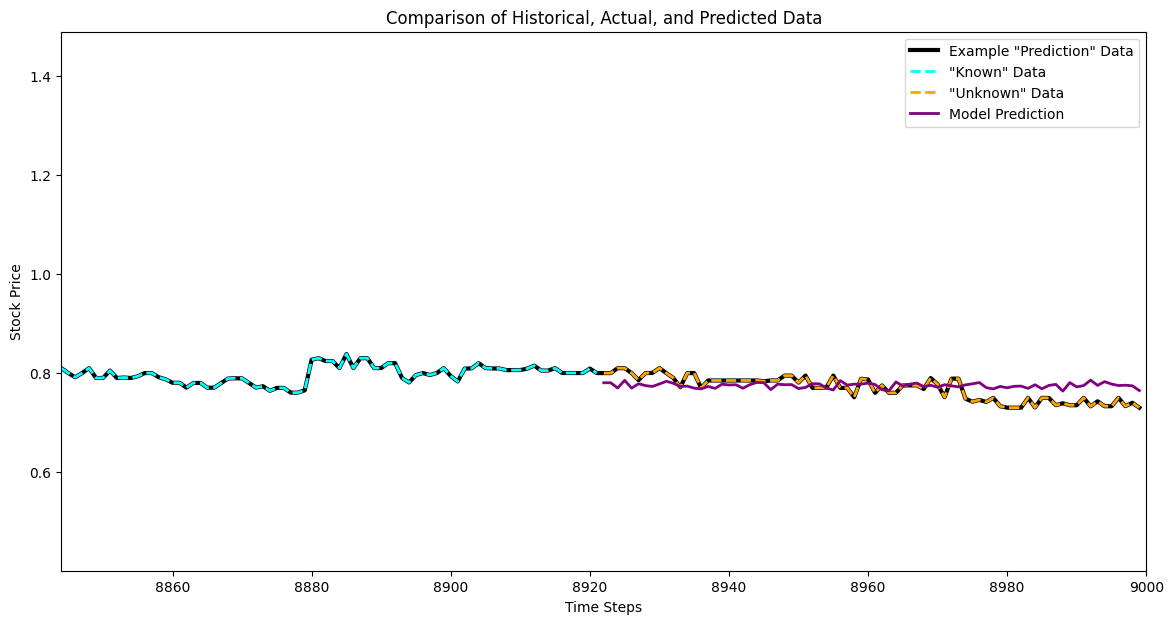

In [315]:
# Plot results
import matplotlib.pyplot as plt

# Create the combined index for plotting
combined_index = np.arange(len(predict_data_whole))

# Create
plt.figure(figsize=(14, 7))

# Plot
plt.plot(combined_index, predict_data_whole['close'], label='Example "Prediction" Data', color='black', linewidth=3.0)
plt.plot(combined_index[split_index_whole:]-78, known_data_whole['close'], label='"Known" Data', color='cyan', linewidth=2.0, linestyle="--")
plt.plot(combined_index[split_index_whole:], unknown_data_whole['close'], label='"Unknown" Data', color='orange', linewidth=2.0, linestyle="--")

plt.plot(combined_index[split_index_whole:], final_predictions[0], label='Model Prediction', color='purple', linewidth=2.0, linestyle="-")



# Format
plt.title('Comparison of Historical, Actual, and Predicted Data')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()

# Adjust y-axis limits based on the data range
# plt.ylim(predict_data_whole.iloc[-200:]['close'].min() - 0.2, predict_data_whole.iloc[-200:]['close'].max() + 0.2)
plt.xlim(len(predict_data_whole) - 156, len(predict_data_whole))  # Crop view to just the very end

# Set y-tick locations with a step of 0.05
# yticks = np.arange(min(predict_data_whole['close']) // 0.05 * 0.05, (max(predict_data_whole['close']) // 0.05 + 1) * 0.05, 0.05)
# plt.yticks(yticks)

plt.show()
